## CA8-1 for Atmospheric Thermodynamic

### Import packages, open file, set parameters, and calculate variables

In [89]:
import numpy as np
import Mog
import matplotlib.pyplot as plt
from scipy import interpolate as intp
import scipy.optimize as opt

# !!!NOTE!!! data is adjusted to ab. decreasing/increasing
H_env,P_env,T_env,qv_env = np.loadtxt(fname='CA8-1_data.txt',dtype=float,usecols=(0,1,2,3),skiprows=1,unpack=True)

# Do some interpolation
X = np.linspace(0,70,71)
Y = np.linspace(0,70,7001)
H_it = intp.interp1d(X, H_env)
P_it = intp.interp1d(X, P_env)
T_it = intp.interp1d(X, T_env)
qv_it = intp.interp1d(X, qv_env)

# variables after interpolate (70->7000)
H_env = H_it(Y)
P_env = P_it(Y)
T_env = T_it(Y)
qv_env = qv_it(Y)

# Set perameters
Q = 0.12  # sensible heat flux [mK/s]
R = 3e-5  # latent heat flux [(kg*m)/(kg*s)]
Rd = Mog.Rd  # [J/K*kg]
Rv = Mog.Rv  # [J/K*kg]
epsilon = Mog.epsilon
g0 = Mog.g0  # [m/s^2]
Cp = Mog.Cp  # [J/K*kg]
Lv = Mog.Lv  # [J/kg]
A = 2.53*10**9  # hPa
B = 5.42*10**3  # K

# Compute variables
es_env = Mog.SaturationWaterVaporPressure(T_env)
qvs_env = Mog.SpecificHumidity(P_env, es_env)
theta_env = Mog.PotentialTemp(T_env,P_env)
hm_env = Mog.MoistStaticEnergy(T_env, H_env, qv_env)
hms_env = Mog.MoistStaticEnergy(T_env, H_env, qvs_env)
Sd_env = Mog.DryStaticEnergy(T_env, H_env)

### Compute Evolution of PBL

In [90]:
# time length
duration = 720

# for comlutation
thetam = theta_env
qvv = qv_env

# to store computation
H_mix = np.zeros(duration + 1)
theta_mix = np.zeros(duration + 1)
qv_mix = np.zeros(duration + 1)
time_index = np.zeros(duration + 1)

# Use min as time unit
for t in range(duration + 1):
    Qt = Q * t * 60
    Rt = R * t * 60

    # initial
    thetas = thetam[0] * H_env[0]  # integral of hm*thetam
    thetamm = thetam[0]  # for record
    qvs = qvv[0] * H_env[0]  # integral of hm*qvm

    for i in range(len(H_env)):

        if (thetamm * H_env[i] - thetas >= Qt):
            H_mix[t] = H_env[i]
            theta_mix[t] = thetamm
            qv_mix[t] = (qvs + Rt)/H_mix[t]
            time_index[t] = i
            break
        
        else:
            if (thetam[i+1] < thetamm):
                thetamm = thetamm
            else:
                thetamm = thetam[i+1]
        
        thetas += (thetam[i] + thetam[i+1]) * (H_env[i+1] - H_env[i]) * 0.5
        qvs += (qvv[i] + qvv[i+1])*(H_env[i+1] - H_env[i]) * 0.5

time_index = np.int_(time_index)  # turn index to integer

Sd_mix = Mog.DryStaticEnergy(T_env[time_index], H_env[time_index])
hm_mix = Mog.MoistStaticEnergy(T_env[time_index], H_env[time_index], qv_mix)
qvs_mix = Mog.SaturatedSpecificHumidity(T_env[time_index], P_env[time_index])
hms_mix = Mog.MoistStaticEnergy(T_env[time_index], H_env[time_index], qvs_mix)

C:\Users\User\AppData\Local\Temp\ipykernel_15176\2366565647.py:29: RuntimeWarning: invalid value encountered in double_scalars
  qv_mix[t] = (qvs + Rt)/H_mix[t]


### Compute $T_c$, LCL, LFC, EL, CAPE, and CIN

In [91]:
# Plot Sd, Hm, Hms, at targeted time
target_index = time_index[-1]

# Variables in PBL
# T
T_in_pbl = theta_mix[-1] * np.ones(target_index) /  ((1000/P_env[:target_index])**(Rd/Cp))
# Sd
Sd_target = Sd_env.copy()
Sd_target[:target_index] = np.ones(target_index) * Sd_env[target_index]
# hm
hm_target = hm_env.copy()
hm_target[:target_index] = np.ones(target_index) * hm_mix[-1]
# hms
hms_target = hms_env.copy()
hms_in_pbl = np.ones(target_index) * Sd_env[target_index] + Lv * Mog.SaturatedSpecificHumidity(T_in_pbl, P_env[:target_index])
hms_target[:target_index] = np.ones(target_index) * hms_in_pbl


def Solve_Tc(Tc):

    '''
    Using numerical method to find Tc
    
    ***Variables below need to be define before calculation.***
    '''

    # Set the values of the variables used in the function
    qvi = qv_env[target_index]
    P0 = P_env[target_index]
    T0 = T_env[target_index]
    epsilon = 0.622
    A = 2.53*10**9
    B = 5420
    kp = Cp/Rd

    # Calculate the value of the function and return it
    f = Tc - B/np.log(((A*epsilon)/(qvi*P0))*(T0/Tc)**kp)
    return f

Tc = opt.bisect(Solve_Tc, 200, 400)

LCL = (T_env[target_index] - Tc)/(g0/Cp) + H_env[target_index]

print('LCL is at %.1f m'%LCL)


# Compute Tv
Tv_target = Mog.VirtualTemp(T_env[time_index], qv_env[time_index])
thetav = Mog.VirtualPotentialTemp(T_env[time_index], qv_env[time_index], P_env[time_index])


LCL is at 1763.5 m


### Plot evolution of $H_{mix}$, $\theta_{mix}$, $q_{v,mix}$, $S_{d,mix}$, $h_{m,mix}$, $h_{ms,mix}$

C:\Users\User\AppData\Local\Temp\ipykernel_15176\478062929.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  cx.set_xticklabels(labels = [0,1,2,3,4,5,6,7,8,9,10,11,12])


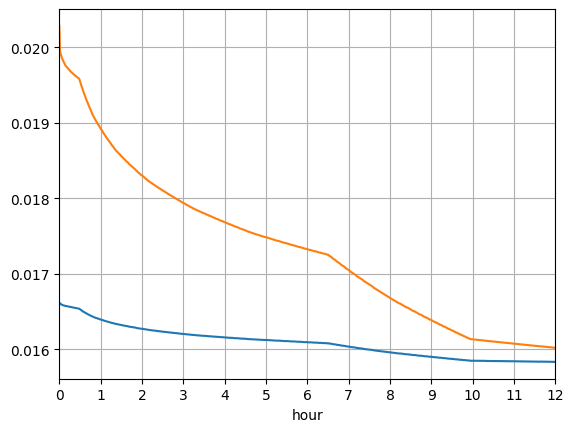

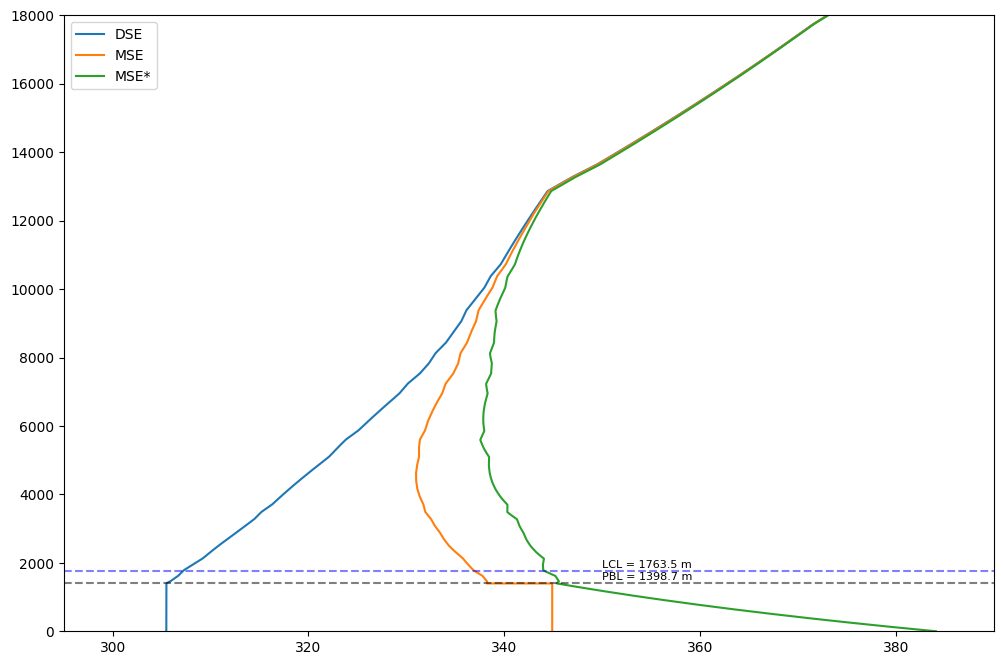

In [102]:
# Plot Sd, Hm, Hms, at targeted time
target_index = time_index[-1]

# Variables in PBL
# T
T_in_pbl = theta_mix[-1] * np.ones(target_index) /  ((1000/P_env[:target_index])**(Rd/Cp))
# Sd
Sd_target = Sd_env.copy()
Sd_target[:target_index] = np.ones(target_index) * Sd_env[target_index]
# hm
hm_target = hm_env.copy()
hm_target[:target_index] = np.ones(target_index) * hm_mix[-1]
# hms
hms_target = hms_env.copy()
hms_in_pbl = np.ones(target_index) * Sd_env[target_index] + Lv * Mog.SaturatedSpecificHumidity(T_in_pbl, P_env[:target_index])
hms_target[:target_index] = np.ones(target_index) * hms_in_pbl

f, ax = plt.subplots(figsize = (12,8))
plt.plot(Sd_target/Cp, H_env)
plt.plot(hm_target/Cp, H_env)
plt.plot(hms_target/Cp, H_env)
plt.axhline(H_env[target_index], linestyle = '--', color = 'black', alpha = 0.5)
plt.axhline(LCL, linestyle = '--', color = 'blue', alpha = 0.5)
plt.text(350, H_env[target_index]+100, 'PBL = %.1f m' %(H_env[target_index]), fontsize = 8)
plt.text(350, LCL+100, 'LCL = %.1f m' %(LCL), fontsize = 8)
plt.legend(['DSE', 'MSE', 'MSE*'], loc = 'upper left')
plt.ylim(0, 18000)
plt.xlim(295,390)
plt.show()

